In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Solving Helmholtz problems

> The models used by the Helmholtz solvers are derived with [Santeri Kaupinmäki](https://bug.medphys.ucl.ac.uk/santeri-kaupinmaki)

Depending on the heterogeneity of the model, the Helmholtz solver automatically calls different functions to calculate the computationally cheapest Helmholtz operator. The solution is always found using an iterative linear solver with matrix-free linear operators.

In [6]:
from jax import numpy as jnp
from jax import jit

# Defining geometry
from jwave.geometry import kGrid, Medium, _circ_mask

N = (128, 256)
dx = (1., 1.)
omega = 1.

# Making geometry
grid = kGrid.make_grid(N, dx)

# Physical properties
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[20:105,20:200].set(1.)
sound_speed = sound_speed*(1-_circ_mask(N, 90,[64,180]))*(1-_circ_mask(N,50,[64,22])) +1

attenuation = jnp.zeros(N)
attenuation = attenuation.at[64:,125:].set(0.03)

density = jnp.ones(N)
density = density.at[:64, 170:].set(1.5)

medium = Medium(
    sound_speed=sound_speed,
    density=density,
    attenuation=attenuation,
    pml_size=15
)

# Source field
src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[64, 22].set(1.0)

A shifted laplacian preconditioner has the form

$$
L = -\nabla^2 - \alpha k^2 I
$$

Which in the fourier basis looks like

$$
L = FF^HL = F(
$$

In [ ]:
from jwave.spectral import derivative

def shift_laplacian_preconditioner(field):
    return jnp.sum(jnp.stack([]), axis=0)

def get_laplacian(grid):
    def lapl(field):
        axis = list(range(field.ndim))

        def deriv(ax):
            return derivative(field, grid, 0, "complex", ax, degree=2)

        return jnp.sum(jnp.stack([deriv(ax) for ax in axis]), axis=0)
    return jit(lapl)

laplacian = get_laplacian(grid)



In [7]:
from jwave.physics import solve_helmholtz

fast_solve = jit(lambda medium, src_field, omega, method: solve_helmholtz(
    grid, medium, src_field, omega, method=method
), static_argnums=(3,))

field = fast_solve(medium, src_field, omega, "bicgstab")

Text(0.5, 1.0, 'Wavefield magnitude')

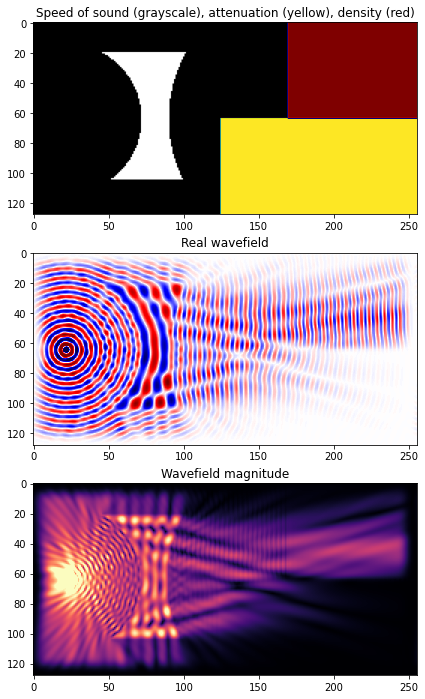

In [8]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3,1,figsize=(17,12))

field = field/jnp.amax(jnp.abs(field))
axes[0].imshow(medium.sound_speed, cmap="gray")
axes[0].imshow(attenuation, alpha=attenuation*100)
axes[0].imshow(density-1, alpha=(density-1)*100, cmap="seismic")
axes[0].set_title("Speed of sound (grayscale), attenuation (yellow), density (red)")
axes[1].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
axes[1].set_title("Real wavefield")
axes[2].imshow(jnp.abs(field), vmin=0, vmax=.2, cmap="magma")
axes[2].set_title("Wavefield magnitude")

# Runtimes

According to [Eerlanga](https://epubs.siam.org/doi/pdf/10.1137/040615195), Bi-CGSTAB is to be preferred to GMRES not only for memory requirements (the number of vectors in memory is fixed to 7, rather than variable as in restarted GMRES), but also because of faster convergence.

Let's check if that's true for Fourier spectral discretization too:

In [25]:
print("Runtime with GMRES")
%timeit fast_solve(medium, src_field, omega, "gmres").block_until_ready()

Runtime with GMRES
1.26 s ± 7.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print("Runtime with Bi-CGSTAB")
%timeit fast_solve(medium, src_field, omega, "bicgstab").block_until_ready()

Runtime with Bi-CGSTAB
817 ms ± 74.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## References

